# Tutorial Opty

This solves the simple pendulum swing up problem presented here:
http://hmc.csuohio.edu/resources/human-motion-seminar-jan-23-2014.
A simple pendulum is controlled by a torque at its joint. The goal is to
swing the pendulum from its rest equilibrium to a target angle by minimizing
the energy used to do so.

In [8]:
import sympy
sympy.__version__

'1.7.1'

## Import statement

In [9]:
from collections import OrderedDict

import numpy as np
import sympy as sym
from opty.direct_collocation import Problem
from opty.utils import building_docs
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Implementation

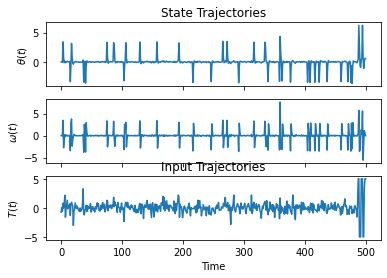

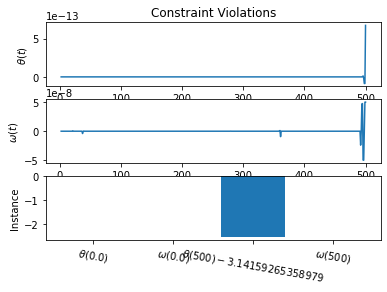

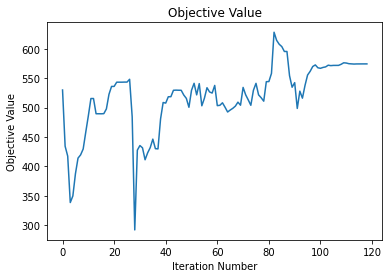

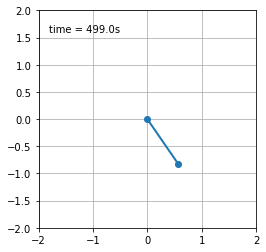

In [15]:
target_angle = np.pi
num_nodes = 500
duration = num_nodes
save_animation = True
gamma = 1. # ADDED
timesteps = np.linspace(0, num_nodes, num_nodes) # ADDED


interval_value = duration / num_nodes

# Symbolic equations of motion
I, m, g, d, t = sym.symbols('I, m, g, d, t')
theta, omega, T = sym.symbols('theta, omega, T', cls=sym.Function)

state_symbols = (theta(t), omega(t))
constant_symbols = (I, m, g, d)
specified_symbols = (T(t),)

eom = sym.Matrix([theta(t).diff() - omega(t),
                  I*(omega(t).diff()) + m*g*d*sym.sin(theta(t)) - T(t)])

# Specify the known system parameters.
par_map = OrderedDict()
par_map[I] = 1.0
par_map[m] = 1.0
par_map[g] = 9.81
par_map[d] = 1.0

# Specify the objective function and it's gradient.
def obj(free):
    """Minimize the sum of the squares of the control torque."""
    T = free[2 * num_nodes:] 
    # Cost = interval_value * np.sum(T**2) # ORIGINAL
    Cost = interval_value * np.sum((gamma**timesteps) * T**2) # ORIGINAL
    return Cost

def obj_grad(free):
    grad = np.zeros_like(free)
    #grad[2 * num_nodes:] = 2.0 * interval_value * free[2 * num_nodes:] # ORIGINAL
    grad[2 * num_nodes:] = 2.0 * interval_value * free[2 * num_nodes:] * gamma ** timesteps # ADDED
    return grad

# Specify the symbolic instance constraints, i.e. initial and end
# conditions.
instance_constraints = (theta(0.0),
                        omega(0.0),
                        theta(duration) - target_angle,
                        omega(duration))

# Create an optimization problem.
prob = Problem(obj, obj_grad, eom, state_symbols, num_nodes, interval_value,
               known_parameter_map=par_map,
               instance_constraints=instance_constraints,
               bounds={T(t): (-5.0, 5.0)})

# Use a random positive initial guess.
initial_guess = np.random.randn(prob.num_free)

# Find the optimal solution.
solution, info = prob.solve(initial_guess)

# Make some plots
prob.plot_trajectories(solution)
prob.plot_constraint_violations(solution)
prob.plot_objective_value()

# Display animation
if not building_docs():
    time = np.linspace(0.0, duration, num=num_nodes)
    angle = solution[:num_nodes]

    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, xlim=(-2, 2),
                         ylim=(-2, 2))
    ax.grid()

    line, = ax.plot([], [], 'o-', lw=2)
    time_template = 'time = {:0.1f}s'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text

    def animate(i):
        x = [0, par_map[d] * np.sin(angle[i])]
        y = [0, -par_map[d] * np.cos(angle[i])]

        line.set_data(x, y)
        time_text.set_text(time_template.format(i * interval_value))
        return line, time_text

    ani = animation.FuncAnimation(fig, animate, np.arange(1, len(time)),
                                  interval=25, blit=True, init_func=init)

    if save_animation:
        ani.save('pendulum_swing_up.mp4', writer='ffmpeg',
                 fps=1 / interval_value)

plt.show()